# Setup

## Imports & Data fetching

In [ ]:
import pandas as pd
import gdown
from matplotlib import pyplot as plt
import numpy as np
import json

def load_dataset():
  def parse_json(data):
    j = json.loads(data)
    return j

  url = 'https://drive.google.com/uc?id=1yvU6ex6T2hgS9gjaIfn4PGxOuzyV3Efr'
  output = 'pull_requests.csv'
  gdown.download(url, output, quiet=False)
  
  df = pd.read_csv('pull_requests.csv', converters={'user': parse_json})
  df.created_at = pd.to_datetime(df.created_at.str.strip('"'), utc=True)
  df.updated_at = pd.to_datetime(df.updated_at.str.strip('"'), utc=True)
  df.closed_at = pd.to_datetime(df.closed_at.str.strip('"'), utc=True)
  df.merged_at = pd.to_datetime(df.merged_at.str.strip('"'), utc=True)
  df.author_association = df.author_association.str.strip('"')
  df['author_username'] = [d.get('login') for d in df.user]
  df['author_user_type'] = [d.get('type') for d in df.user]
  return df
  

def load_repo_data(file_name, url):
  gdown.download(url, file_name, quiet=False)
  df = pd.read_csv(file_name)
  return df

In [ ]:
df = load_dataset()
df_repo_contributors = load_repo_data('repo_contributors.csv', 'https://drive.google.com/uc?id=19Z_QVluJ35bMTXQ5DnvH0vBaQ9rho7Ts')
df_repo_sizes = load_repo_data('repositories_java_and_total_size.csv', 'https://drive.google.com/uc?id=1P1jJ5l7iEZyhCd3ikPpn5JcOyasypC7U')

Downloading...
From: https://drive.google.com/uc?id=1yvU6ex6T2hgS9gjaIfn4PGxOuzyV3Efr
To: /content/pull_requests.csv
100%|██████████| 707M/707M [00:04<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=19Z_QVluJ35bMTXQ5DnvH0vBaQ9rho7Ts
To: /content/repo_contributors.csv
100%|██████████| 2.66M/2.66M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P1jJ5l7iEZyhCd3ikPpn5JcOyasypC7U
To: /content/repositories_java_and_total_size.csv
100%|██████████| 17.5k/17.5k [00:00<00:00, 7.56MB/s]

               repo_name     user_name user_type
0            Neamar/KISS        Neamar      User
1            Neamar/KISS       weblate      User
2            Neamar/KISS       nmitsou      User
3            Neamar/KISS       ntninja      User
4            Neamar/KISS  comradekingu      User
...                  ...           ...       ...
72460  apache/cloudstack        kjiang      User
72461  apache/cloudstack     yusa-aist      User
72462  apache/cloudstack   krissterckx      User
72463  apache/cloudstack     loganmc10      User
72464  apache/cloudstack   Lucasgranet      User

[72465 rows x 3 columns]


## Data preparation & aggregations

In [ ]:
def bytes_to_mb(bytes):
  return bytes/1048576

# compute additional columns about repo sizes
df_repo_sizes['proportion_java'] = df_repo_sizes['bytes']/df_repo_sizes['repo_size']
df_repo_sizes['mbytes'] = bytes_to_mb(df_repo_sizes['bytes'])
df_repo_sizes['repo_size_mbytes'] = bytes_to_mb(df_repo_sizes['repo_size'])


The Dataframe 'repo_pr_stats_df' contains aggregated meta information about repositories.

index: repository name  
Columns:  
> pr_total: # total PRs of this repo  
> pr_closed: # closed PRs of this repo  
> pr_closed_merged: # closed and merged PRs of this repo  
> pr_closed_not_merged: # closed and not merged PRs of this repo  




In [ ]:
# group all PRs by repository
pr_grouped_by_repo = df.groupby(['name'])

repo_pr_stats = {}

# iterate over every group (one group containing all PRs of one repo)
for repo_name, group_df in pr_grouped_by_repo:
  closed = group_df[group_df.state == '"closed"'] # only closed PR
  closed_merged = closed[closed.merged == True] # only closed and merged PR
  closed_not_merged = closed[closed.merged == False] # only closed and not merged PR

  pr_total = group_df.shape[0]
  pr_closed = closed.shape[0]
  pr_closed_merged = closed_merged.shape[0]
  pr_closed_not_merged = closed_not_merged.shape[0]

  repo_pr_stats[repo_name] = {
      'pr_total': pr_total,
      'pr_closed': pr_closed,
      'pr_closed_merged': pr_closed_merged,
      'pr_closed_not_merged': pr_closed_not_merged,
  }
  
repo_pr_stats_df = pd.DataFrame.from_dict(repo_pr_stats, orient='index')
repo_pr_stats_df['acceptance_rate'] = repo_pr_stats_df['pr_closed_merged']/repo_pr_stats_df['pr_closed']
repo_pr_stats_df['rejection_rate'] = repo_pr_stats_df['pr_closed_not_merged']/repo_pr_stats_df['pr_closed']


In [ ]:
# lst = df_repo_sizes['repo_name'].to_list()
# print(len(lst))
# repo_size_avail = repo_pr_stats_df
# # temp_df.rename(columns = {'index':'repo_name'}, inplace=True)
# #temp_df
# lst
# repo_size_avail = temp_df
# repo_size_avail[~repo_size_avail['repo_name'].isin(lst)]

# print(len(lst))
# print(repo_size_avail)




In [ ]:
print(repo_pr_stats_df.columns)
print(repo_pr_stats_df.head(5))
print(repo_pr_stats_df.describe)

print(f'max number of PRs:\t{repo_pr_stats_df["pr_total"].max()}')
print(f'min number of PRs:\t{repo_pr_stats_df["pr_total"].min()}')

Index(['pr_total', 'pr_closed', 'pr_closed_merged', 'pr_closed_not_merged',
       'acceptance_rate', 'rejection_rate'],
      dtype='object')
                                 pr_total  ...  rejection_rate
00-Evan/shattered-pixel-dungeon        10  ...        1.000000
1hakr/AnExplorer                        1  ...        1.000000
201206030/fiction_house                 1  ...             NaN
201206030/novel-plus                    7  ...        0.500000
2227324689/gpmall                      26  ...        0.058824

[5 rows x 6 columns]
<bound method NDFrame.describe of                                  pr_total  ...  rejection_rate
00-Evan/shattered-pixel-dungeon        10  ...        1.000000
1hakr/AnExplorer                        1  ...        1.000000
201206030/fiction_house                 1  ...             NaN
201206030/novel-plus                    7  ...        0.500000
2227324689/gpmall                      26  ...        0.058824
...                                   ...  ..

In [ ]:
# print(repo_size_avail.columns)
# print(repo_size_avail.describe)

# print(f'max number of PRs:\t{temp_df["pr_total"].max()}')
# print(f'min number of PRs:\t{temp_df["pr_total"].min()}')

In [ ]:
# TODO: there seems to be some inconsistency between the different datasets in regards to amount of repositories
# querying the repositories 'dinuscxj/CircleProgressBar' and 'dinuscxj/RecyclerRefreshLayout' do not return any contributors for some reason

repos_count_1 = len(df['name'].unique())
print(f'In the df dataset there are {repos_count_1} unique repos.')

repos_count_2 = len(df_repo_contributors['repo_name'].unique())
print(f'In the df_repo_contributors dataset there are {repos_count_2} unique repos.')

repos_count_3 = len(df_repo_sizes['repo_name'].unique())
print(f'In the df_repo_sizes dataset there are {repos_count_3} unique repos.')

for el in df['name'].unique():
  if el not in df_repo_contributors.values:
    print(el)


In the df dataset there are 870 unique repos.
In the df_repo_contributors dataset there are 868 unique repos.
In the df_repo_sizes dataset there are 413 unique repos.
dinuscxj/CircleProgressBar
dinuscxj/RecyclerRefreshLayout


In [ ]:
# example of PR data structure
print(df.iloc[0])
print('############################################################################')
print(f'Repository Names and Contributors: \n{df_repo_contributors.iloc[0]}')
print('############################################################################')
print(f'Repository Names, Bytes written in Java and Project Size: \n{df_repo_sizes.iloc[0]}')

name                                                        Neamar/KISS
state                                                            "open"
title                 "Resolve remaining bugs with 'Show history wit...
body                  "This solves the three issues listed here: htt...
created_at                                    2021-10-23 00:56:11+00:00
updated_at                                    2021-10-23 00:56:11+00:00
closed_at                                                           NaT
merged_at                                                           NaT
author_association                                          CONTRIBUTOR
auto_merge                                                          NaN
merged                                                            False
comments                                                              0
review_comments                                                       0
commits                                                         

# Helpers

In [ ]:
def generate_hist_boxplot_fig(data, bins, ylabel, xlabel, text_pos='left'):
  # compute some data metrics
  desc = data.describe()
  mean, median, std = desc['mean'], desc['50%'], desc['std']

  # initialize figure and subplots
  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

  # plot histogram
  ax1.hist(data, bins=bins)
  ax1.set_ylabel(ylabel)
  mean, median, std = desc['mean'], desc['50%'], desc['std']
  text_pos_x = 0.1 if text_pos == 'left' else 0.7
  text_pos_y = 0.8
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax1.text(text_pos_x, text_pos_y, f'Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}', ha='left', va='center', transform=ax1.transAxes, bbox=props)

  # plot boxplot
  ax2.boxplot(data, vert=False, showfliers=False)
  ax2.set_xlabel(xlabel)
  ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

  return fig


def calculate_acceptance(df):
  if df.size < 10:
    print(f'Warning: bin size: {df.size} < 10')
  
  df['acceptance_rate'] = df[df.merged_at.notnull()].size/df[df.closed_at.notnull()].size
  return df

# Descriptive Statistics

## Distribution of Project Sizes

Quantiles:
count    413.000000
mean       8.179739
std       26.664107
min        0.000603
25%        0.679194
50%        2.149971
75%        6.600470
max      413.586309
Name: mbytes, dtype: float64


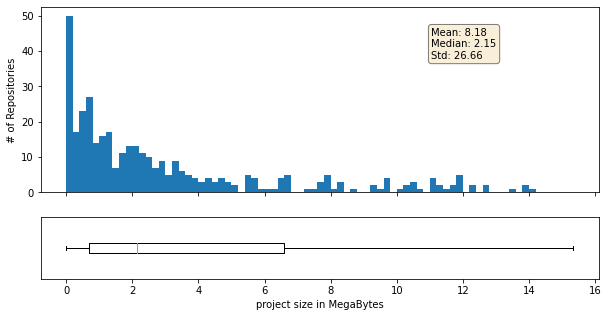

In [ ]:
# repo_sizes_in_mb = pd.DataFrame([bytes_to_mb(bytes) for bytes in df_repo_sizes['repo_size']])

print('Quantiles:')
desc = df_repo_sizes['mbytes'].describe()
print(desc)

fig = generate_hist_boxplot_fig(df_repo_sizes['mbytes'], np.arange(0,15,0.2), '# of Repositories', 'project size in MegaBytes', text_pos='right')
fig.show()


## Distribution of Code Size in Java

Quantiles:
count    413.000000
mean       9.416137
std       27.789438
min        0.000603
25%        0.798358
50%        2.482765
75%        7.735537
max      413.790936
Name: repo_size_mbytes, dtype: float64


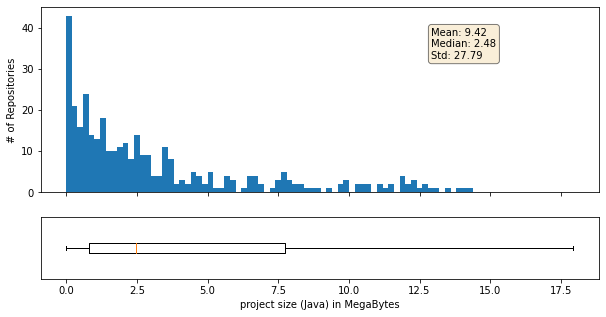

In [ ]:
print('Quantiles:')
desc = df_repo_sizes['repo_size_mbytes'].describe()
print(desc)

fig = generate_hist_boxplot_fig(df_repo_sizes['repo_size_mbytes'], np.arange(0,15,0.2), '# of Repositories', 'project size (Java) in MegaBytes', text_pos='right')
fig.show()

## Distribution of Proportion of Project Size and Code Size in Java

Quantiles:
count    413.000000
mean       0.881340
std        0.172635
min        0.146850
25%        0.832534
50%        0.971175
75%        0.996978
max        1.000000
Name: proportion_java, dtype: float64


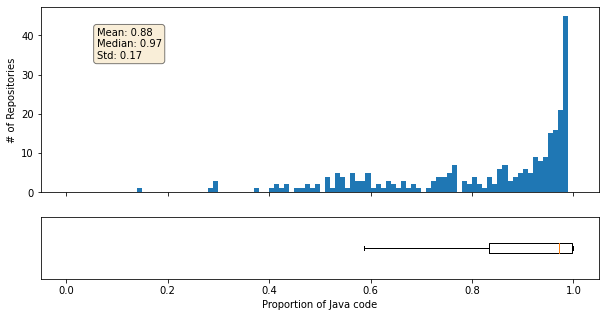

In [ ]:
print('Quantiles:')
desc = df_repo_sizes['proportion_java'].describe()
print(desc)

fig = generate_hist_boxplot_fig(df_repo_sizes['proportion_java'], np.arange(0,1,0.01), '# of Repositories', 'Proportion of Java code')
fig.show()

## Distribution of Number of Contributors

count    868.000000
mean      83.485023
std       93.969005
min        1.000000
25%       14.000000
50%       46.500000
75%      117.000000
max      426.000000
dtype: float64
author_user_type
Bot      25472
User    263004
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Bots acceptance rate: [0.62373016]
Users acceptance rate: [0.75658752]


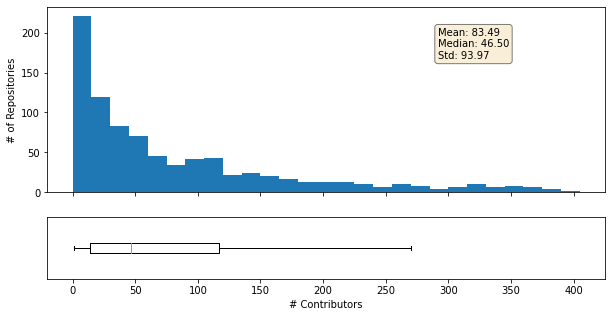

In [ ]:
contributors_per_repo = df_repo_contributors.groupby(['repo_name']).size()
desc = contributors_per_repo.describe()
print(desc)

fig = generate_hist_boxplot_fig(contributors_per_repo, np.arange(0,420,15), '# of Repositories', '# Contributors', text_pos='right')
fig.show()

print(df.groupby('author_user_type').size())
df_bots = df[df['author_user_type'] == 'Bot']
df_users = df[df['author_user_type'] == 'User']

print(f"Bots acceptance rate: {calculate_acceptance(df_bots)['acceptance_rate'].unique()}")
print(f"Users acceptance rate: {calculate_acceptance(df_users)['acceptance_rate'].unique()}")

## Distribution of PRs across repositories

count      870.000000
mean       331.581609
std       1002.440133
min          1.000000
25%          7.000000
50%         45.000000
75%        232.500000
max      17724.000000
Name: pr_count, dtype: float64
46775
288476


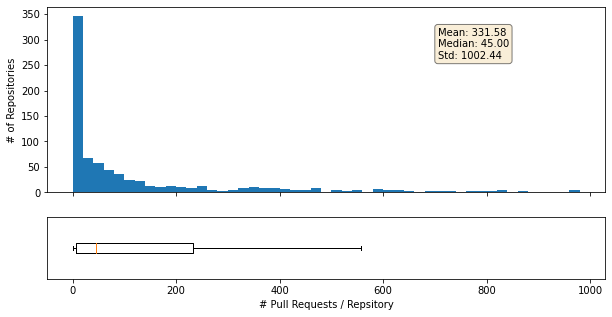

In [ ]:
repository_pr = df.groupby(['name']).size().reset_index(name='pr_count')
desc = repository_pr.pr_count.describe()
print(desc)

fig = generate_hist_boxplot_fig(repository_pr.pr_count, np.arange(0, 1000, 20), '# of Repositories', '# Pull Requests / Repsitory', text_pos='right')
fig.show()

print(repository_pr.sort_values(by='pr_count', ascending=False).head()['pr_count'].sum())
print(repository_pr.pr_count.sum())

## Deletions

'\ndeletions = df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]\n\nprint(pd.cut(df.deletions, 50, retbins=True))\n'

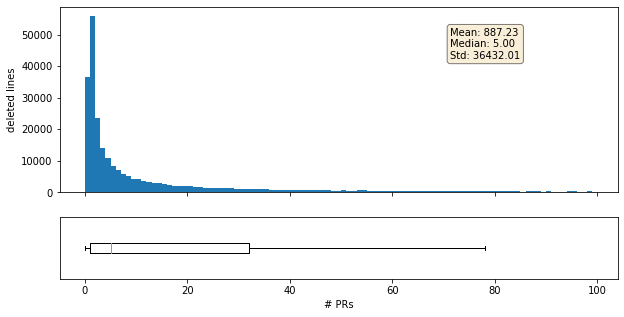

In [ ]:
fig = generate_hist_boxplot_fig(df.deletions, np.arange(0, 100, 1), 'deleted lines', '# PRs', text_pos='right')
fig.show()

# TODO: this didn't compile for me
'''
deletions = df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]

print(pd.cut(df.deletions, 50, retbins=True))
'''

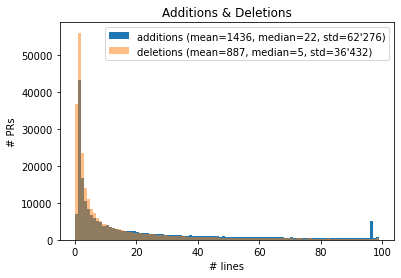

In [ ]:
plt.hist(df.additions, bins=np.arange(0, 100, 1), label='additions (mean=1436, median=22, std=62\'276)')
plt.hist(df.deletions, bins=np.arange(0, 100, 1),  alpha=0.5, label='deletions (mean=887, median=5, std=36\'432)')
plt.title('Additions & Deletions')
plt.xlabel('# lines')
plt.ylabel('# PRs')
plt.legend()
plt.show()

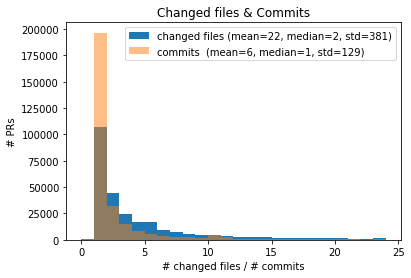

In [ ]:
plt.hist(df.changed_files, bins=np.arange(0, 25, 1), label='changed files (mean=22, median=2, std=381)')
plt.hist(df.commits, bins=np.arange(0, 25, 1),  alpha=0.5, label='commits  (mean=6, median=1, std=129)')
plt.title('Changed files & Commits')
plt.xlabel('# changed files / # commits')
plt.ylabel('# PRs')
plt.legend()
plt.show()

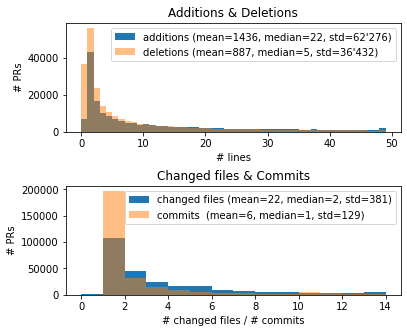

In [ ]:
fig, axs = plt.subplots(2)

axs[0].hist(df.additions, bins=np.arange(0, 50, 1), label='additions (mean=1436, median=22, std=62\'276)')
axs[0].hist(df.deletions, bins=np.arange(0, 50, 1),  alpha=0.5, label='deletions (mean=887, median=5, std=36\'432)')
axs[0].set_title('Additions & Deletions')
axs[0].set_xlabel('# lines')
axs[0].set_ylabel('# PRs')
axs[0].legend()

axs[1].hist(df.changed_files, bins=np.arange(0, 15, 1), label='changed files (mean=22, median=2, std=381)')
axs[1].hist(df.commits, bins=np.arange(0, 15, 1),  alpha=0.5, label='commits  (mean=6, median=1, std=129)')
axs[1].set_title('Changed files & Commits')
axs[1].set_xlabel('# changed files / # commits')
axs[1].set_ylabel('# PRs')
axs[1].legend()
fig.set_figheight(7)

plt.subplots_adjust(hspace=0.5)
fig.set_figheight(5)
# axs[1].show()

## Additions

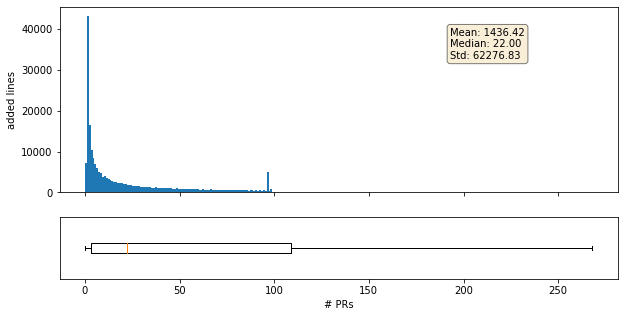

In [ ]:
fig = generate_hist_boxplot_fig(df.additions, np.arange(0, 100, 1), 'added lines', '# PRs', text_pos='right')
fig.show()
# Julius
# TODO: Calcualte ration additions/deletions per PR

## Changed Files

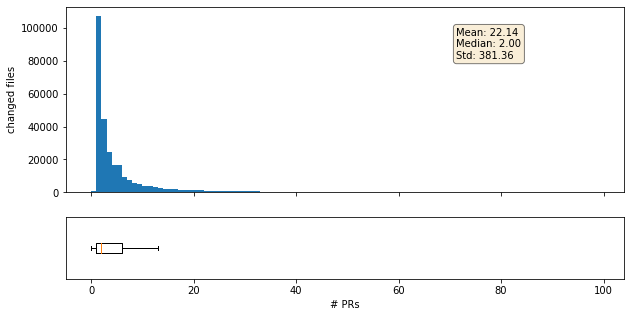

In [ ]:
fig = generate_hist_boxplot_fig(df.changed_files, np.arange(0, 100, 1), 'changed files', '# PRs', text_pos='right')
fig.show()

## Commits

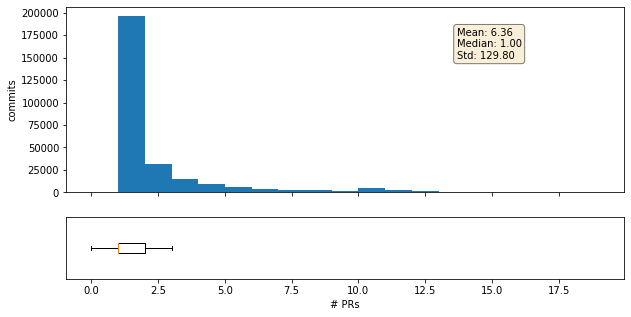

In [ ]:
fig = generate_hist_boxplot_fig(df.commits, np.arange(0, 20, 1), 'commits', '# PRs', text_pos='right')
fig.show()

In [ ]:
print(df.groupby('commits').size())
print(df.commits.size)

commits
0           498
1        196510
2         31713
3         15117
4          8729
          ...  
7430          2
8857          2
9513          3
9719          1
10000        32
Length: 572, dtype: int64
288476


## State

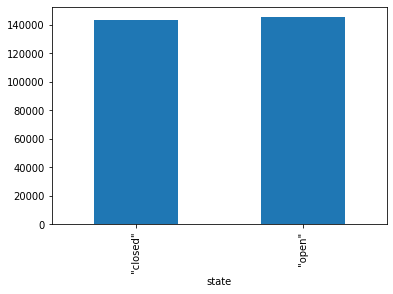

In [ ]:
states = df.groupby(['state']).size()
states.plot(kind='bar')

## Comments

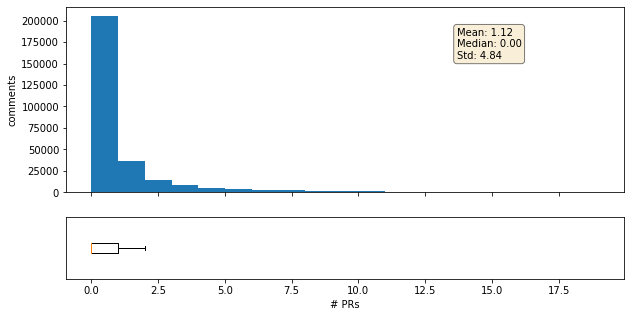

In [ ]:
fig = generate_hist_boxplot_fig(df.comments, np.arange(0, 20, 1), 'comments', '# PRs', text_pos='right')
fig.show()

## Review Comments

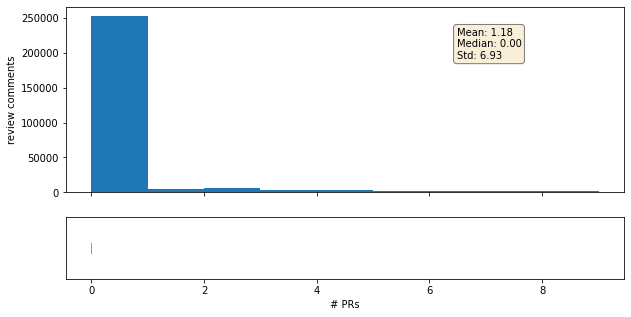

In [ ]:
fig = generate_hist_boxplot_fig(df.review_comments, np.arange(0, 10, 1), 'review comments', '# PRs', text_pos='right')
fig.show()

## Merged

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


PR acceptance ratios / repo
count    288245.000000
mean          0.744356
std           0.241853
min           0.000000
25%           0.718310
50%           0.831566
75%           0.899661
max           1.000000
Name: acceptance_by_repo, dtype: float64


Text(0.5, 1.0, 'Accepted vs. Rejected PRs')

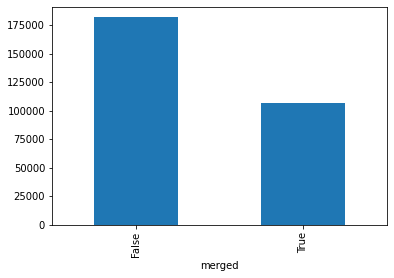

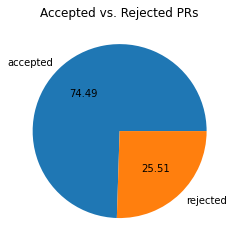

In [ ]:
def calculate_acceptance_by_repo(df):
  df['acceptance_by_repo'] = df[df.merged_at.notnull()].size / df[df.closed_at.notnull()].size
  return df

df_ = df.groupby(['name']).apply(calculate_acceptance_by_repo)
print('PR acceptance ratios / repo')
print(df_.acceptance_by_repo.describe())

merged = df.groupby(['merged']).size()
merged.plot(kind='bar')

closed = df[df.closed_at.notnull()]
merged = df[df.merged_at.notnull()]
merged_closed_ratio = (merged.merged_at.size / closed.closed_at.size)
rejected_closed_ratio = ((closed.closed_at.size - merged.merged_at.size) / closed.closed_at.size)

fig = plt.figure()
plt.pie([merged_closed_ratio, rejected_closed_ratio], labels=['accepted', 'rejected'], autopct='%.2f')
plt.title('Accepted vs. Rejected PRs')

## Hours to close

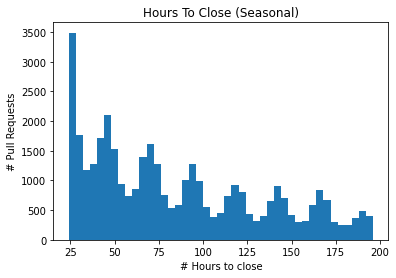

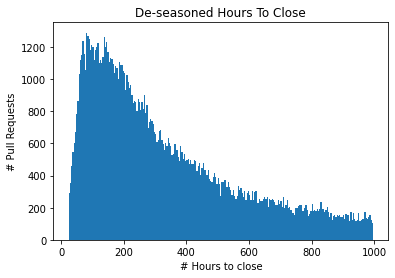

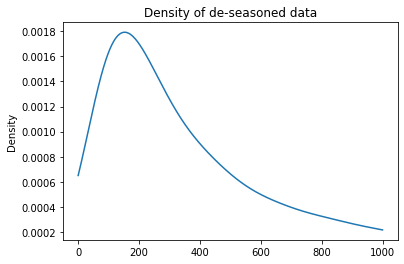

In [ ]:
df['days_to_close'] = (df.closed_at - df.created_at).dt.days
df['hours_to_close'] = (df.closed_at - df.created_at).dt.total_seconds()/3600
mask = df.days_to_close.notna()
hours_to_close = df.hours_to_close[mask]
plt.hist(hours_to_close, bins=np.arange(24, 200, 4))
plt.title('Hours To Close (Seasonal)')
plt.xlabel('# Hours to close')
plt.ylabel('# Pull Requests')



# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.figure()
df['hours_to_close_deseasoned'] = hours_to_close.rolling(window=24).mean()
plt.hist(df['hours_to_close_deseasoned'], bins= np.arange(24, 1000, 4))
plt.title('De-seasoned Hours To Close')
plt.xlabel('# Hours to close')
plt.ylabel('# Pull Requests')
# plt.text(0.43, 0.2, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)


plt.figure()
df['hours_to_close_deseasoned'].plot.density(ind=np.arange(0, 1000), title='Density of de-seasoned data')


## Hours to merge

count    106574.000000
mean        192.216759
std         983.030469
min           0.000833
25%           1.398403
50%          16.636667
75%          92.119514
max       58530.744167
Name: hours_to_merge, dtype: float64


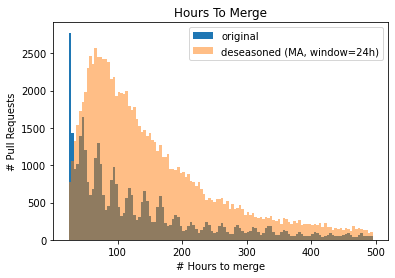

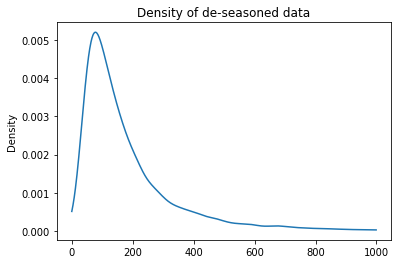

In [ ]:
df['days_to_merge'] = (df.merged_at - df.created_at).dt.days
df['hours_to_merge'] = (df.merged_at - df.created_at).dt.total_seconds()/3600
mask = df.hours_to_merge.notna()
hours_to_merge = df.hours_to_merge[mask]
print(hours_to_merge.describe())
plt.hist(hours_to_merge, bins=np.arange(24, 500, 4), label='original')
plt.xlabel('# Hours to merge')
plt.ylabel('# Pull Requests')

df['hours_to_merge_deseasoned'] = hours_to_merge.rolling(window=24).mean()
plt.hist(df['hours_to_merge_deseasoned'], bins= np.arange(24, 500, 4), label='deseasoned (MA, window=24h)', alpha=0.5)
plt.title('Hours To Merge')
plt.xlabel('# Hours to merge')
plt.ylabel('# Pull Requests')
plt.legend()

plt.figure()
df['hours_to_merge_deseasoned'].plot.density(ind=np.arange(0, 1000), title='Density of de-seasoned data')

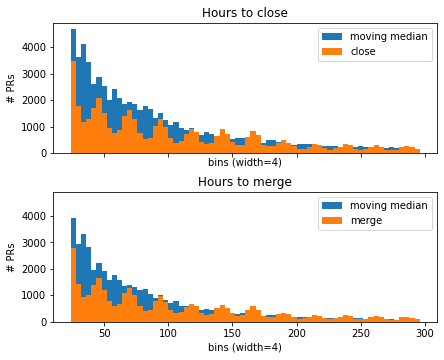

In [ ]:
fig, axis = plt.subplots(2, sharex=True, sharey=True)

axis[0].hist(hours_to_close.rolling(window=4).median(), bins=np.arange(24, 300, 4), alpha=1, label='moving median')
axis[0].hist(df.hours_to_close, bins=np.arange(24, 300, 4), label='close')
axis[0].set_title('Hours to close')
axis[0].set_ylabel('# PRs')
axis[0].set_xlabel('bins (width=4)')
axis[0].legend()
axis[1].hist(hours_to_merge.rolling(window=4).median(), bins=np.arange(24, 300, 4), alpha=1, label='moving median')
axis[1].hist(df.hours_to_merge, bins=np.arange(24, 300, 4), label='merge')
axis[1].set_title('Hours to merge')
axis[1].set_ylabel('# PRs')
axis[1].set_xlabel('bins (width=4)')
axis[1].legend()

fig.tight_layout(pad=0.1)
fig.set_figheight(5)
# plt.hist(df.hours_to_merge, bins=np.arange(24, 300, 4), label='merge', alpha=1)
# plt.
# plt.title('Hours to close / merge')
# plt.ylabel('# PRs')
# plt.xlabel('hours (bins width = 4)')
# plt.plot(df.hours_to_close_deseasoned/8, bins=np.arange(24, 500, 4), label='hours to close (deseasoned)', alpha=0.5)
# plt.hist(df.hours_to_merge_deseasoned, bins=np.arange(24, 300, 4), label='hours to merge (deseasoned)', alpha=0.5)
# plt.ylim(0, 2000)


## Author Association

author_association
COLLABORATOR     5.887838
CONTRIBUTOR     55.276695
MEMBER          23.947573
NONE            14.515592
OWNER            0.372301
dtype: float64


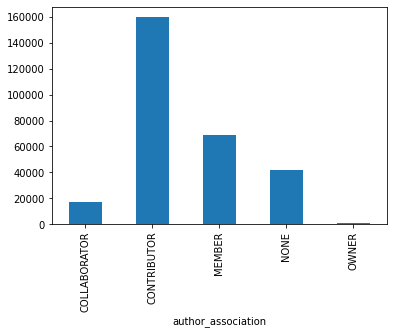

In [ ]:
# author association distribution
author_association = df.groupby(['author_association']).size()
author_association.plot(kind='bar')

print(author_association / df.commits.size * 100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


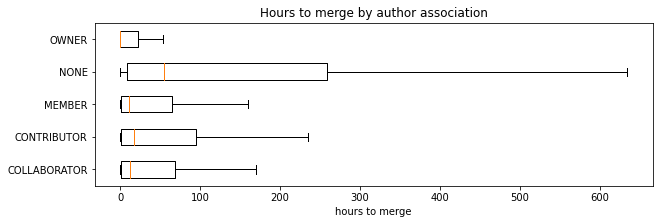

In [ ]:
author_association_days_to_merge_distribution = df.pivot(columns='author_association', values='hours_to_merge')
ass_merge_dist = author_association_days_to_merge_distribution # shorthand ..

boxplot_data = {}

# iterate over every association type (i.e. 'COLLABORATOR', 'OWNER', ..)
for association_type in ass_merge_dist:
  # filter out rows (i.e. PRs) of the specific association type
  data = ass_merge_dist[association_type][~np.isnan(ass_merge_dist[association_type])]
  boxplot_data[association_type] = data


fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(boxplot_data.values(), vert=False, showfliers=False)
ax.set_yticklabels(boxplot_data.keys())
ax.set_xlabel('hours to merge')
ax.set_title('Hours to merge by author association')
fig.show()
fig.set_figheight(3)


#author_association_days_to_merge_distribution.plot.density()
#plt.xlabel("days to merge PR")
#plt.xlim(-5, 5)

#author_association_days_to_close_distribution = df.pivot(columns='author_association', values='days_to_close')
#author_association_days_to_close_distribution.plot.density()
#plt.xlabel("days to close PR")
#plt.xlim(-5, 5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


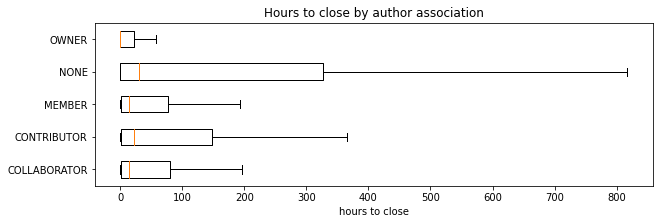

In [ ]:
author_association_days_to_close_distribution = df.pivot(columns='author_association', values='hours_to_close')
ass_close_dist = author_association_days_to_close_distribution # shorthand ..

boxplot_data = {}

# iterate over every association type (i.e. 'COLLABORATOR', 'OWNER', ..)
for association_type in ass_merge_dist:
  # filter out rows (i.e. PRs) of the specific association type
  data = ass_close_dist[association_type][~np.isnan(ass_close_dist[association_type])]
  boxplot_data[association_type] = data


fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(boxplot_data.values(), vert=False, showfliers=False)
ax.set_yticklabels(boxplot_data.keys())
ax.set_xlabel('hours to close')
ax.set_title('Hours to close by author association')
fig.set_figheight(3)

fig.show()

# RQ1
We suspect that besides qualitative metrics, quantitative metrics like number of additions, deletions and file changes negatively correlate to the acceptance rate of PRs

In [ ]:
def remove_outliers(df, feature, band=3):
  return df[np.abs(df[feature]-df[feature].mean()) <= (band*df[feature].std())]

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_in_bin_acceptance_rate(df, feature, max, bin_width=1):
  df = remove_outliers(df, feature, 2)
  df = df.loc[df[feature] < max]
  cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)

  df = df.groupby(cuts).apply(calculate_acceptance)
  df = df.groupby(cuts).first()
  df = remove_outliers(df, 'acceptance_rate', band=3)
  
  window = 4
  acceptance_rate_ma = df.acceptance_rate.rolling(window=window).mean()

  X = np.arange(0, df.acceptance_rate.size).reshape(-1, 1)
  Y = df.acceptance_rate.values.reshape(-1, 1)
  linear_regressor = LinearRegression()
  linear_regressor.fit(X, Y)
  Y_pred = linear_regressor.predict(X)

  ma = np.array(acceptance_rate_ma).reshape(-1,1).T
  mask = np.ma.masked_invalid(ma).mask
  corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  orig_stats = df.acceptance_rate.describe()
  mean_orig = orig_stats['mean']
  std_orig = orig_stats['std']

  ma_stats = acceptance_rate_ma.describe()
  mean_ma = ma_stats['mean']
  std_ma = ma_stats['std']

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  fig = plt.figure()
  plt.plot(df.acceptance_rate, label='original')
  plt.plot(acceptance_rate_ma, label=f'MA (window={window})')
  plt.plot(Y_pred, color='lime', label='linear regression')
  plt.title(f'PR acceptance rate vs. {feature}')
  plt.xlabel(f'{feature} (bin width: {bin_width})')
  plt.ylabel('acceptance rate')
  plt.ylim(0, 1)
  plt.text(0.43, 0.26, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  plt.legend()
  # fig.tight_layout()
  fig.set_figheight(1.75)

In [ ]:
# First, lets consider closed PRs only (accepted or rejected)
closed = df[df.closed_at.notnull()]
closed['changed_files_commits'] = closed.changed_files + closed.commits
closed['all'] = closed.additions + closed.deletions + closed.changed_files + closed.commits
closed['additions_deletions'] = closed.additions - closed.deletions

# plot_in_bin_acceptance_rate(df=closed, feature='additions_deletions', bin_width=1, max=500)

# plot_in_bin_acceptance_rate(df=closed, feature='additions', bin_width=5, max=1000)
# plot_in_bin_acceptance_rate(df=closed, feature='deletions', bin_width=5, max=1000)
# plot_in_bin_acceptance_rate(df=closed, feature='changed_files', bin_width=1, max=150)
# plot_in_bin_acceptance_rate(df=closed, feature='commits', bin_width=1, max=150)
# plot_in_bin_acceptance_rate(df=closed, feature='comments', bin_width=1, max=15)
# plot_in_bin_acceptance_rate(df=closed, feature='review_comments', bin_width=1, max=15)
# plot_in_bin_acceptance_rate(df=closed, feature='changed_files_commits', bin_width=1, max=150)
# plot_in_bin_acceptance_rate(df=closed, feature='all', bin_width=1, max=350)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
  # df = closed
  # feature = 'additions'
  # bin_width = 1
  # max=1000

  # df = remove_outliers(df, feature, 2)
  # df = df.loc[df[feature] < max]
  # cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)

  # df = df.groupby(cuts).apply(calculate_acceptance)
  # df = df.groupby(cuts).first()
  # df = remove_outliers(df, 'acceptance_rate', band=3)
  
  # window = int(max**0.5)
  # acceptance_rate_ma = df.acceptance_rate.rolling(window=window).mean()

  # X = np.arange(0, df.acceptance_rate.size).reshape(-1, 1)
  # Y = df.acceptance_rate.values.reshape(-1, 1)
  # linear_regressor = LinearRegression()
  # linear_regressor.fit(X, Y)
  # Y_pred = linear_regressor.predict(X)

  # ma = np.array(acceptance_rate_ma).reshape(-1,1).T
  # mask = np.ma.masked_invalid(ma).mask
  # corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  # corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  # orig_stats = df.acceptance_rate.describe()
  # mean_orig = orig_stats['mean']
  # std_orig = orig_stats['std']

  # ma_stats = acceptance_rate_ma.describe()
  # mean_ma = ma_stats['mean']
  # std_ma = ma_stats['std']

  # fig, axs = plt.subplots(2, sharey=False, sharex=False)

  # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # # plt.figure()
  # axs[0].plot(df.acceptance_rate, label='original')
  # axs[0].plot(acceptance_rate_ma, label=f'MA (window={window})')
  # axs[0].plot(Y_pred, color='lime', label='linear regression')
  # axs[0].set_title(f' {feature} vs. PR acceptance rate')
  # axs[0].set_xlabel(f'{feature} (bin width: {bin_width})')
  # axs[0].set_ylabel('acceptance rate')
  # axs[0].set_ylim(0, 1)
  # axs[0].text(0.48, 0.67, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  # axs[0].legend()



  # df = closed
  # feature = 'deletions'
  # bin_width = 1
  # max=500

  # df = remove_outliers(df, feature, 2)
  # df = df.loc[df[feature] < max]
  # cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)

  # df = df.groupby(cuts).apply(calculate_acceptance)
  # df = df.groupby(cuts).first()
  # df = remove_outliers(df, 'acceptance_rate', band=3)
  
  # window = int(max**0.5)
  # acceptance_rate_ma = df.acceptance_rate.rolling(window=window).mean()

  # X = np.arange(0, df.acceptance_rate.size).reshape(-1, 1)
  # Y = df.acceptance_rate.values.reshape(-1, 1)
  # linear_regressor = LinearRegression()
  # linear_regressor.fit(X, Y)
  # Y_pred = linear_regressor.predict(X)

  # ma = np.array(acceptance_rate_ma).reshape(-1,1).T
  # mask = np.ma.masked_invalid(ma).mask
  # corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  # corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  # orig_stats = df.acceptance_rate.describe()
  # mean_orig = orig_stats['mean']
  # std_orig = orig_stats['std']

  # ma_stats = acceptance_rate_ma.describe()
  # mean_ma = ma_stats['mean']
  # std_ma = ma_stats['std']

  # # fig, axs = plt.subplots(2)

  # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # # plt.figure()
  # axs[1].plot(df.acceptance_rate, label='original')
  # axs[1].plot(acceptance_rate_ma, label=f'MA (window={window})')
  # axs[1].plot(Y_pred, color='lime', label='linear regression')
  # axs[1].set_title(f'{feature} vs. PR acceptance rate')
  # axs[1].set_xlabel(f'{feature} (bin width: {bin_width})')
  # axs[1].set_ylabel('acceptance rate')
  # axs[1].set_ylim(0, 1)
  # axs[1].text(0.48, 0.17, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  # axs[1].legend()
  # fig.tight_layout(pad=0.1)
  # # fig.set_figheight(7)

In [ ]:
  # df = closed
  # feature = 'commits'
  # bin_width = 1
  # max=150

  # df = remove_outliers(df, feature, 2)
  # df = df.loc[df[feature] < max]
  # cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)

  # df = df.groupby(cuts).apply(calculate_acceptance)
  # df = df.groupby(cuts).first()
  # df = remove_outliers(df, 'acceptance_rate', band=3)
  
  # window = int(max**0.5)
  # acceptance_rate_ma = df.acceptance_rate.rolling(window=window).mean()

  # X = np.arange(0, df.acceptance_rate.size).reshape(-1, 1)
  # Y = df.acceptance_rate.values.reshape(-1, 1)
  # linear_regressor = LinearRegression()
  # linear_regressor.fit(X, Y)
  # Y_pred = linear_regressor.predict(X)

  # ma = np.array(acceptance_rate_ma).reshape(-1,1).T
  # mask = np.ma.masked_invalid(ma).mask
  # corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  # corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  # orig_stats = df.acceptance_rate.describe()
  # mean_orig = orig_stats['mean']
  # std_orig = orig_stats['std']

  # ma_stats = acceptance_rate_ma.describe()
  # mean_ma = ma_stats['mean']
  # std_ma = ma_stats['std']

  # fig, axs = plt.subplots(2, sharey=False, sharex=False)

  # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # # plt.figure()
  # axs[0].plot(df.acceptance_rate, label='original')
  # axs[0].plot(acceptance_rate_ma, label=f'MA (window={window})')
  # axs[0].plot(Y_pred, color='lime', label='linear regression')
  # axs[0].set_title(f' {feature} vs. PR acceptance rate')
  # axs[0].set_xlabel(f'{feature} (bin width: {bin_width})')
  # axs[0].set_ylabel('acceptance rate')
  # axs[0].set_ylim(0, 1)
  # axs[0].text(0.48, 0.67, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  # axs[0].legend()



  # df = closed
  # feature = 'changed_files'
  # bin_width = 1
  # max=150

  # df = remove_outliers(df, feature, 2)
  # df = df.loc[df[feature] < max]
  # cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)

  # df = df.groupby(cuts).apply(calculate_acceptance)
  # df = df.groupby(cuts).first()
  # df = remove_outliers(df, 'acceptance_rate', band=3)
  
  # window = int(max**0.5)
  # acceptance_rate_ma = df.acceptance_rate.rolling(window=window).mean()

  # X = np.arange(0, df.acceptance_rate.size).reshape(-1, 1)
  # Y = df.acceptance_rate.values.reshape(-1, 1)
  # linear_regressor = LinearRegression()
  # linear_regressor.fit(X, Y)
  # Y_pred = linear_regressor.predict(X)

  # ma = np.array(acceptance_rate_ma).reshape(-1,1).T
  # mask = np.ma.masked_invalid(ma).mask
  # corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  # corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  # orig_stats = df.acceptance_rate.describe()
  # mean_orig = orig_stats['mean']
  # std_orig = orig_stats['std']

  # ma_stats = acceptance_rate_ma.describe()
  # mean_ma = ma_stats['mean']
  # std_ma = ma_stats['std']

  # # fig, axs = plt.subplots(2)

  # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # # plt.figure()
  # axs[1].plot(df.acceptance_rate, label='original')
  # axs[1].plot(acceptance_rate_ma, label=f'MA (window={window})')
  # axs[1].plot(Y_pred, color='lime', label='linear regression')
  # axs[1].set_title(f'{feature} vs. PR acceptance rate')
  # axs[1].set_xlabel(f'{feature} (bin width: {bin_width})')
  # axs[1].set_ylabel('acceptance rate')
  # axs[1].set_ylim(0, 1)
  # axs[1].text(0.48, 0.17, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  # axs[1].legend()
  # fig.tight_layout(pad=0.1)
  # # fig.set_figheight(7)

#RQ2
We suspect that the number of contributors (repository) negatively correlates with the acceptance rate of PRs

In [ ]:
df_contributors_per_repo = df_repo_contributors.groupby(by='repo_name').count()
df_repo_contributors_and_acceptancec_rates = pd.merge(left=repo_pr_stats_df, right=df_contributors_per_repo, how='inner', left_index=True, right_on='repo_name')

df_repo_contributors_and_acceptancec_rates['user_name']

print('Correlation contributors  {}'.format(df_repo_contributors_and_acceptancec_rates['user_name'].corr(df_repo_contributors_and_acceptancec_rates['acceptance_rate'])))

Correlation contributors  0.15054273847198407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


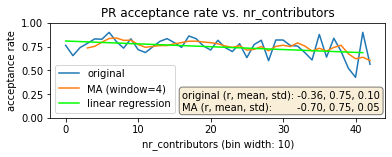

In [ ]:
df_ = df.set_index(['name'], drop=False)
df_.loc[df_repo_contributors_and_acceptancec_rates.index, 'nr_contributors'] = df_repo_contributors_and_acceptancec_rates['user_name']
df_.reset_index(inplace=True, drop=True)

plot_in_bin_acceptance_rate(df=df_, feature='nr_contributors', bin_width=10, max=450)

In [ ]:
def calcualte_hours_to_close(df):
  if df.size < 10:
    print(f'Warning: bin size: {df.size} < 10')
  hours_to_merge_mean = df[df.hours_to_close.notnull()].hours_to_close.mean()
  
  
  df['hours_to_close'] = hours_to_merge_mean
  return df


In [ ]:
from sklearn.linear_model import LinearRegression

def plot_in_bin_hours_to_close(df, feature, max, bin_width=1):
  df = remove_outliers(df, feature, 2)
  df = df.loc[df[feature] < max]
  cuts = pd.cut(df[feature], np.arange(0, max, bin_width), include_lowest=True)
  df = df.groupby(cuts).apply(calcualte_hours_to_close)
  df = df.groupby(cuts).first()
  print(df.hours_to_close)
  df = remove_outliers(df, 'hours_to_close', band=3)
  window = 4
  hours_to_close_ma = df.hours_to_close.rolling(window=window).mean()

  X = np.arange(0, df.hours_to_close.size).reshape(-1, 1)
  Y = df.hours_to_close.values.reshape(-1, 1)
  linear_regressor = LinearRegression()
  linear_regressor.fit(X, Y)
  Y_pred = linear_regressor.predict(X)



  ma = np.array(hours_to_close_ma).reshape(-1,1).T
  mask = np.ma.masked_invalid(ma).mask
  corr_ma = np.corrcoef(ma[~mask], X.T[~mask])[0][1]

  corr_orig = np.corrcoef(Y.T, X.T)[0][1]

  orig_stats = df.hours_to_close.describe()
  mean_orig = orig_stats['mean']
  std_orig = orig_stats['std']

  ma_stats = hours_to_close_ma.describe()
  mean_ma = ma_stats['mean']
  std_ma = ma_stats['std']

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  fig = plt.figure()
  plt.plot(df.hours_to_close, label='original')
  plt.plot(hours_to_close_ma, label=f'MA (window={window})')
  plt.plot(Y_pred, color='lime', label='linear regression')
  plt.title(f'Hours to close rate vs. {feature}')
  plt.xlabel(f'{feature} (bin width: {bin_width})')
  plt.ylabel('hours to close')
  # plt.ylim(0, 1)
  plt.text(0.43, 0.2, f'original (r, mean, std): {corr_orig:3.2f}, {mean_orig:3.2f}, {std_orig:3.2f}\nMA (r, mean, std):        {corr_ma:3.2f}, {mean_ma:3.2f}, {std_ma:3.2f}', ha='left', va='center', bbox=props, transform=plt.gcf().transFigure)
  plt.legend()
  # fig.set_figheight(2)

nr_contributors
(-0.001, 10.0]     438.251244
(10.0, 20.0]      1422.925879
(20.0, 30.0]       712.276794
(30.0, 40.0]       794.784137
(40.0, 50.0]       169.777453
(50.0, 60.0]       318.169183
(60.0, 70.0]       344.000829
(70.0, 80.0]       433.748208
(80.0, 90.0]       664.124407
(90.0, 100.0]      520.324673
(100.0, 110.0]     897.836312
(110.0, 120.0]     561.132384
(120.0, 130.0]     404.306512
(130.0, 140.0]     571.560556
(140.0, 150.0]     543.277268
(150.0, 160.0]     458.035490
(160.0, 170.0]     743.579333
(170.0, 180.0]     292.951599
(180.0, 190.0]     509.751577
(190.0, 200.0]     753.177632
(200.0, 210.0]     877.783757
(210.0, 220.0]     280.062853
(220.0, 230.0]     665.417159
(230.0, 240.0]     626.180705
(240.0, 250.0]    1199.843711
(250.0, 260.0]    1058.154631
(260.0, 270.0]     395.878769
(270.0, 280.0]     492.174627
(280.0, 290.0]     672.380134
(290.0, 300.0]     807.176677
(300.0, 310.0]     316.435336
(310.0, 320.0]     722.501584
(320.0, 330.0]    1063.0

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


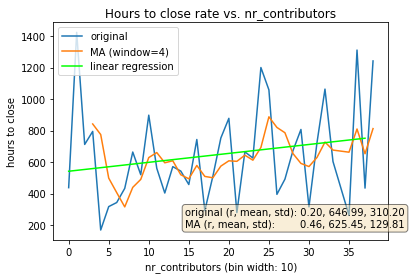

In [ ]:
df_ = closed.set_index(['name'], drop=False)
result = df_.join(df_repo_contributors_and_acceptancec_rates['user_name'])
result.reset_index(inplace=True, drop=True)
result['nr_contributors'] = result['user_name']

plot_in_bin_hours_to_close(df=result, feature='nr_contributors', bin_width=10, max=400)


#RQ3 
We suspect that the number of bytes or project size (repository) negatively correlates with the acceptance rate of PRs

Acceptance rate correlations to:
repo size	-0.08673228085798582
java size	-0.06663736154344838
java proportion	0.0817855661385855


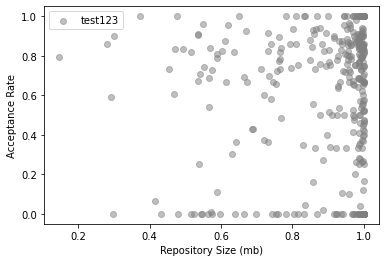

In [ ]:
# Andy

df_repo_sizes_and_acceptance_rates = pd.merge(left=repo_pr_stats_df, right=df_repo_sizes, how='inner', left_index=True, right_on='repo_name')

corr_dict = {
    'repo_size_acceptance': df_repo_sizes_and_acceptance_rates['repo_size_mbytes'].corr(df_repo_sizes_and_acceptance_rates['acceptance_rate']),
    'java_size_acceptance': df_repo_sizes_and_acceptance_rates['mbytes'].corr(df_repo_sizes_and_acceptance_rates['acceptance_rate']),
    'java_proportion_acceptance': df_repo_sizes_and_acceptance_rates['proportion_java'].corr(df_repo_sizes_and_acceptance_rates['acceptance_rate']),
    'repo_size_rejection': df_repo_sizes_and_acceptance_rates['repo_size_mbytes'].corr(df_repo_sizes_and_acceptance_rates['rejection_rate']),
    'java_size_rejection': df_repo_sizes_and_acceptance_rates['mbytes'].corr(df_repo_sizes_and_acceptance_rates['rejection_rate']),
    'java_proportion_rejection': df_repo_sizes_and_acceptance_rates['proportion_java'].corr(df_repo_sizes_and_acceptance_rates['rejection_rate'])
}


print('Acceptance rate correlations to:\nrepo size\t{}\njava size\t{}\njava proportion\t{}'.format(corr_dict['repo_size_acceptance'], corr_dict['java_size_acceptance'], corr_dict['java_proportion_acceptance']))
# print('Rejection rate correlations to:\nrepo size\t{}\njava size\t{}\njava proportion\t{}'.format(corr_dict['repo_size_rejection'], corr_dict['java_size_rejection'], corr_dict['java_proportion_rejection']))

plt.scatter(df_repo_sizes_and_acceptance_rates['proportion_java'], df_repo_sizes_and_acceptance_rates['acceptance_rate'], alpha=0.5, c='grey', label='test123')

plt.legend()
plt.xlabel('Repository Size (mb)')
plt.ylabel('Acceptance Rate')

plt.show()



count    122060.000000
mean         39.562613
std          66.630254
min           0.000603
25%           4.777772
50%          11.539011
75%          40.138073
max         413.790936
Name: repo_size, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


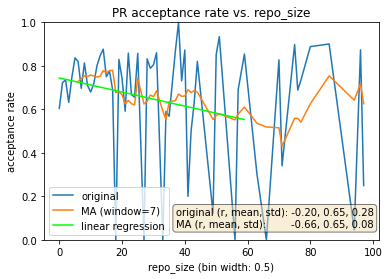

In [ ]:
df_ = df_repo_sizes_and_acceptance_rates.set_index(keys=['repo_name'])
df__ = df.set_index(keys=['name'])
df__.loc[df_.index, 'repo_size'] = df_['repo_size_mbytes']
df__.reset_index(inplace=True)
df__  = df__.loc[df__.repo_size.notnull()]

#print(df__.repo_size.unique())
print(df__.repo_size.describe())

plot_in_bin_acceptance_rate(df=df__, feature='repo_size', bin_width=0.5, max=50)